In this notebook I have tried to find the best suitable machine learning model to predict house prices.

**Note:** I have done a lot of parameter tuning for each model, but I can't every step in notebook. So I have filtered the steps and added only important ones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import numpy.random as rnd
rnd.seed(42)

In [3]:
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import Imputer,StandardScaler

I have just copies the classes and functions  defined in EDA notebook

In [4]:
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin

class FeaturesAdder(BaseEstimator,TransformerMixin):
    """This class adds new features in the dataset.
        Features added are : rooms_per_household, bedrooms_per_room, and population_per_household.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X['rooms_per_household']=X['total_rooms']/X['households']
        X['bedrooms_per_room']=X['total_bedrooms']/X['total_rooms']
        X['population_per_household']=X['population']/X['households']
        return X


class RemoveOutliers(BaseEstimator,TransformerMixin):
    """This class removes outliers from data.
    Note: Outlier values are hard coded
    """
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X=X[(X['median_house_value']!=500001) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[X['median_income']<=11].reset_index(drop=True)
        X=X[(X['median_house_value']!=350000) | (X['median_income']>=1.5)].reset_index(drop=True)
        X=X[(X['median_house_value']!=450000) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[(X['median_house_value']>=350000) | (X['median_income']<=9.5)].reset_index(drop=True)
        X=X[X['population']<=9000]
        X=X[(X['population_per_household']>=1.15) & (X['population_per_household']<=6.5)]
        X=X[X['rooms_per_household']<20]
        X=X[X['bedrooms_per_room']<0.5].reset_index(drop=True)
        return X
    

class FeaturesTransformer(BaseEstimator,TransformerMixin):
    """This class trnsforms numberical featuress in the dataset.
    Note: Transformations are hard coded.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        import numpy as np
        from scipy.special import boxcox1p        
        X['total_rooms']=X['total_rooms'].apply(lambda x: boxcox1p(x,0.25))
        X['total_bedrooms']=X['total_bedrooms'].apply(lambda x: boxcox1p(x,0.25))
        X['households']=X['households'].apply(lambda x: boxcox1p(x,0.2))
        X['population']=X['population'].apply(lambda x: boxcox1p(x,0.3))
        X['rooms_per_household']=X['rooms_per_household'].apply(lambda x: np.log1p(x)**0.5)
        X['bedrooms_per_room']=X['bedrooms_per_room'].apply(lambda x: np.log1p(x)**0.25)
        X['median_income']=X['median_income'].apply(lambda x: np.log1p(x)**1.25)
        X['population_per_household']=X['population_per_household'].apply(lambda x: np.log1p(x)**1)
        return X
    

class DataFrameSelector(BaseEstimator,TransformerMixin):
    """This class is a dataframe selector.
        Data members:
            features: A list of column_names you want in output dataframe
    """
    def __init__(self,features):
        self.features=features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.features]

class GetDummies(BaseEstimator,TransformerMixin):
    """This class is used to get dummy columns from categorical columns."""
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        #change ISLAND to NEAR BAY...as count of ISLAND is very low
        X[X=='ISLAND']='NEAR BAY'
        return (pd.get_dummies(X,drop_first=True))

In [5]:
def remove_by_pvalue(X,y,pvalue=0.05):
    """Remove features with p-value more than 'pvalue'
    
    This function uses statsmodels.api.OLS model. Please add intercept to data externally.
    Input:
        X: Array or dataframe excluding predicted variable
        y: Series or list of predicted variable
        pvalue: int or float
    
    Note:
        X is changed inplace
    """
    import statsmodels.api as sm
    for i in range(len(X.columns)):
        regressor_OLS=sm.OLS(endog=y,exog=X).fit()
        s=regressor_OLS.pvalues.sort_values(ascending=False)
        if s.iloc[0]>pvalue:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],'P-value: ',s.iloc[0])
        
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],', VIF: ',s.iloc[0])
        else:
            break


### Making Train Data Ready

I have done the same operations on data as discussed in EDA notebook

In [6]:
df=pd.read_csv('strat_train_set.csv')

In [7]:
#Adding features
df=FeaturesAdder().fit_transform(df)

num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

#Removing outliers
df=RemoveOutliers().fit_transform(df)

data_labels=df['median_house_value']
df=df.drop('median_house_value',axis=1)

#Transforming features
df=FeaturesTransformer().fit_transform(df)

num_features=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household','bedrooms_per_room', 'population_per_household']
cat_featues=['ocean_proximity']

#Mean value imputation, feature scaling, gettin gdummy variables
num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_features)),
    ('imputer',Imputer(strategy='median')),
    ('std_scaler',StandardScaler())
])

cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_featues)),
    ('get_dummies',GetDummies())
])

#Combining numerical and categorica data
data_cleaning_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),  
])

df=data_cleaning_pipeline.fit_transform(df)

l=num_features.copy()
l.extend([0,1,2])
df=pd.DataFrame(df,columns=l)

#Check for multicoliniearity
remove_by_vif(df)
remove_by_pvalue(df,data_labels)

data_prepared=df
y_train=data_labels.copy()

label_scaler=StandardScaler()
data_labels=label_scaler.fit_transform(y_train.values.reshape(-1,1))

C:\Users\dbda\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dbda\Anaconda3\lib\site-packages\pandas\core\frame.py:2366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
C:\Users\dbda\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Removed:  total_bedrooms , VIF:  558.923557961
Removed:  households , VIF:  228.174136543
Removed:  total_rooms , VIF:  108.348134348
Removed:  latitude , VIF:  18.3371368814
Removed:  bedrooms_per_room , VIF:  5.61881879787


In [8]:
data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16005 entries, 0 to 16004
Data columns (total 9 columns):
longitude                   16005 non-null float64
housing_median_age          16005 non-null float64
population                  16005 non-null float64
median_income               16005 non-null float64
rooms_per_household         16005 non-null float64
population_per_household    16005 non-null float64
0                           16005 non-null float64
1                           16005 non-null float64
2                           16005 non-null float64
dtypes: float64(9)
memory usage: 1.1 MB


## Choosing ML Algorithm

In [9]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split
from sklearn.model_selection import GridSearchCV

In [10]:
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plot validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()


### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression,Ridge

In [12]:
lr=LinearRegression()
scores=cross_val_score(lr,data_prepared,data_labels,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.799186299388


To calculate RMSE I have used 'train_y' which are unscaled labels.

In [13]:
lr=LinearRegression()
scores=cross_val_score(lr,data_prepared,y_train,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  67960.7878003


So with linear regression,

R-squared=0.8

RMSE=67960.78

RMSE of above model is 67960 which means that there's an average error of $67960 in prediction of house price.

### Ridge Regression

In [14]:
ridge=Ridge(alpha=0.1,random_state=42)
scores=cross_val_score(ridge,data_prepared,data_labels,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.799186315957


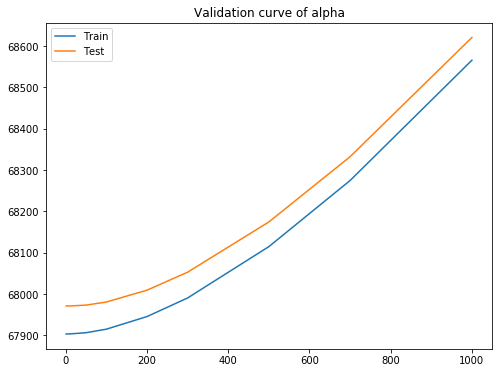

In [15]:
ridge=Ridge(random_state=42)
param_name='alpha'
param_range = [1,10,50,100,200,300,500,700,1000]
#param_range=[1,10,100,800,900,1000,1200,1400,1600,1800,2000]
#scoring='r2'
scoring='neg_mean_squared_error'
curve=validation_curve(ridge,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)

n=len(param_range)
'''if scoring=='r2':
    train_score=[curve[0][i].mean() for i in range (0,n)]
    test_score=[curve[1][i].mean() for i in range (0,n)]
elif scoring=='neg_mean_squared_error':
    train_score=[np.sqrt(-curve[0][i].mean()) for i in range (0,n)]
    test_score=[np.sqrt(-curve[1][i].mean()) for i in range (0,n)]
    '''

plot_validation_curve(curve,param_range,param_name,scoring)

From above plot It can be seen that Train and Test scores are almost after alpha=700.

Even at alpha=0, difference between RMSE is not much, so there is no objectionable overfitting.
As alpha is increased, bias is increasing and so the RMSE.

As linear regression is not overfitting the model, using Ridge regression is not necessary.

### Support Vector Regression
I have used this to use kernel trick with support vector machines and for polynomial features using RBF kernel.

In [16]:
from sklearn.svm import SVR

In [17]:
svr=SVR(degree=2)
param_grid={
    'C':[1,10,50,100]
}
scoring='r2'
grid=GridSearchCV(svr,param_grid,scoring=scoring,n_jobs=-1,cv=3,verbose=3)
grid.fit(data_prepared,data_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   10.9s remaining:   54.7s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.1min remaining:   45.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished
C:\Users\dbda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 10, 50, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='r2', verbose=3)

In [18]:
print(grid.best_params_)
#print(grid.best_score_)

{'C': 10}


In [19]:
svr=SVR(degree=2,C=10)
scores=cross_val_score(svr,data_prepared,data_labels,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.878012135913


So, with support vector machines

R2=0.878

which is better than Linear Regression model

### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
dtr=DecisionTreeRegressor(random_state=42)
scores=cross_val_score(dtr,data_prepared,y_train,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.757175224163


So, basic decision tree model is giving

R2=0.7571

Then I did some parameter tuning so get best decision tree model.

**max_depth**

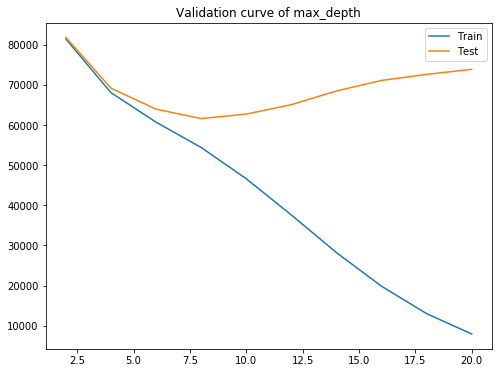

In [22]:
dtr=DecisionTreeRegressor(random_state=42)
param_name='max_depth'
param_range = range(2,21,2)
scoring='neg_mean_squared_error'
curve=validation_curve(dtr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)

plot_validation_curve(curve,param_range,param_name,scoring)

From above diagram it is clear that model starts overfitting heavily after max_depth=8

max_depth: 3 to 8

**max_features**

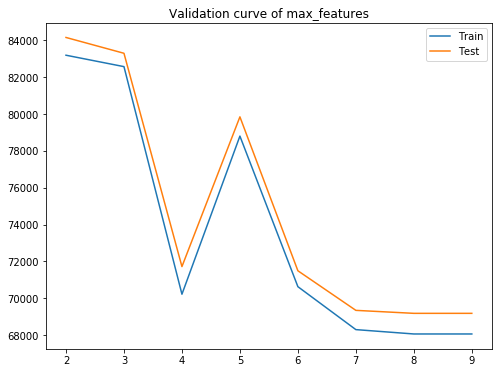

In [23]:
dtr=DecisionTreeRegressor(max_depth=4,random_state=42)
param_name='max_features'
param_range = range(2,10)
scoring='neg_mean_squared_error'
curve=validation_curve(dtr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)
plot_validation_curve(curve,param_range,param_name,scoring)

max_features: 6 to 9

**min_samples_split**

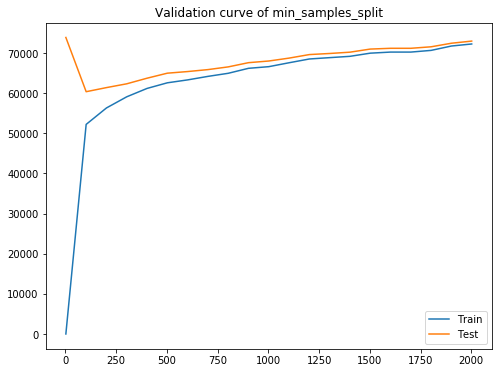

In [24]:
dtr=DecisionTreeRegressor(random_state=42)
param_name='min_samples_split'
param_range = range(2,2003,100)
scoring='neg_mean_squared_error'
curve=validation_curve(dtr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)
plot_validation_curve(curve,param_range,param_name,scoring)

With incresing min_samples_split after 200, variance is reducing

**min_samples_leaf**

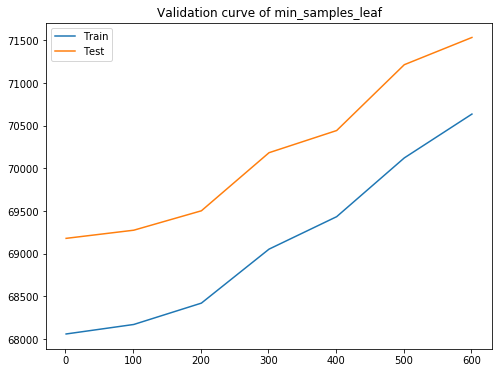

In [25]:
dtr=DecisionTreeRegressor(max_depth=4,random_state=42)
param_name='min_samples_leaf'
param_range = range(1,701,100)
scoring='neg_mean_squared_error'
curve=validation_curve(dtr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)
plot_validation_curve(curve,param_range,param_name,scoring)

Increasing min_samples_leaf is neither giving good results nor helping to reduce overfitting.

### Gradient Boosting Regression
I used this ensembling method to get the best model from decision trees.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
gbr=GradientBoostingRegressor(random_state=42)
param_grid={
    'n_estimators':[100,500,1000],
    'max_depth':range(3,9,1),
    'max_features':[6,7,9],
    'min_samples_split':[200,400]  
}
scoring='r2'
grid=GridSearchCV(gbr,param_grid,scoring=scoring,n_jobs=-1,cv=3,verbose=1)
grid.fit(data_prepared,y_train)
print(grid.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.4min finished


{'max_depth': 8, 'max_features': 6, 'min_samples_split': 200, 'n_estimators': 100}


Check for **n_estimators**

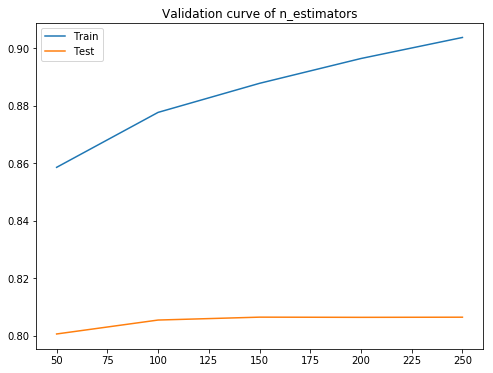

In [28]:
gbr=GradientBoostingRegressor(max_depth= 8, max_features=6, min_samples_split=200,random_state=42)
param_name='n_estimators'
param_range = range(50,251,50)
scoring='r2'
curve=validation_curve(gbr,data_prepared,y_train,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1)
plot_validation_curve(curve,param_range,param_name,scoring)

With increasing number of estimators, model is overfitting.
With lower number of estimators, model is underfitting.

I chose **n_estimators**=100

In [29]:
gbr=GradientBoostingRegressor(max_depth= 8, max_features=6, min_samples_split=200, n_estimators=100,random_state=42)
scores=cross_val_score(gbr,data_prepared,y_train,n_jobs=-1,cv=5,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.897464355204


With above GradientBosting model

R2=0.897

This model is even better than support vector regressor.

### Stacking
This is another ensembling method.

In this, I have used Linear regression and Gradient boosing regression  as base models and Support Vector Regression as meta model.

In [30]:
from mlxtend.regressor import StackingRegressor

In [31]:
lr=LinearRegression()
svr=SVR(degree=2,C=10)
gbr=GradientBoostingRegressor(max_depth= 8, max_features=6, min_samples_split=200, n_estimators=100,random_state=42)

In [32]:
sr=StackingRegressor([lr,gbr],svr,verbose=3)
scores=cross_val_score(sr,data_prepared,data_labels,n_jobs=-1,cv=3,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.892142951903


For stacking,

R2=0.892

This is less than Gradient Boosting Regressor.

### Final Model:

I finalized following Gradient Boosing Regressor with following parameters:

1. n_estimators=100
2. max_depth=8
3. max_features=6
4. min_samples_split=200


## Learning Curve

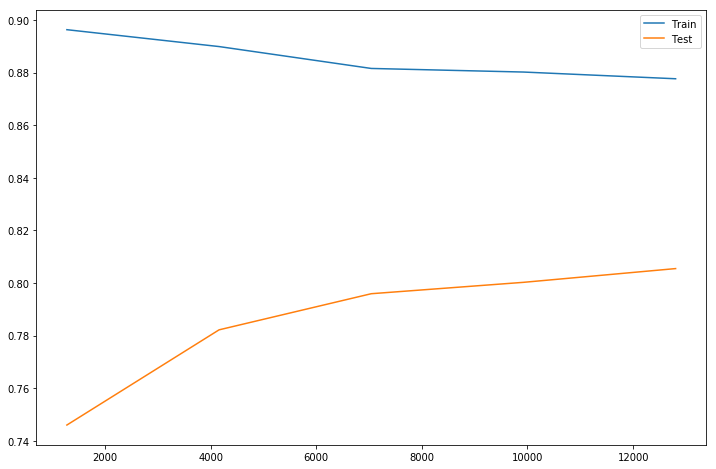

In [33]:
gbr=GradientBoostingRegressor(max_depth= 8, max_features=6, min_samples_split=200, n_estimators=100,random_state=42)
lc=learning_curve(gbr,data_prepared,y_train,cv=5,n_jobs=-1)
size=lc[0]
train_score=[lc[1][i].mean() for i in range (0,5)]
test_score=[lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(12,8))
plt.plot(size,train_score,label='Train')
plt.plot(size,test_score,label="Test")
plt.legend()

From learning curve it is clear that this model is still overfitting.
But, with the increase in number of samples, variance is decreasing.

So, getting more training data can be a solution for overfitting.

## Predicting on Test Set

In [34]:
test_data=pd.read_csv('strat_test_set.csv')
test_data_labels=test_data['median_house_value'].copy()
test_data.drop('median_house_value',axis=1,inplace=True)

I did following data manupulations on test data
1. Adding features
2. Transforming skewed features

In [35]:
fa=FeaturesAdder()
df_test=fa.fit_transform(test_data)

df_test=FeaturesTransformer().fit_transform(df_test)

#used 'transform' method, as I don't want to refit the standard scalar on test data.
df_test=data_cleaning_pipeline.transform(df_test)

df_test=pd.DataFrame(df_test,columns=l)

C:\Users\dbda\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dbda\Anaconda3\lib\site-packages\pandas\core\frame.py:2366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


Scaling test data labels

In [36]:
#used 'transform' method, as I don't want to refit the standard scalar on test data.

y_test=test_data_labels.copy()
test_data_labels=label_scaler.transform(y_test.values.reshape(-1,1))

Choosing same columns of test_data as of train_data

In [37]:
test_data_prepared=df_test[data_prepared.columns]

In [38]:
gbr=GradientBoostingRegressor(max_depth= 8, max_features=6, min_samples_split=200, n_estimators=100,random_state=42)
gbr.fit(data_prepared,data_labels)
train_pred=gbr.predict(data_prepared)
test_pred=gbr.predict(test_data_prepared)

C:\Users\dbda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
mse=mean_squared_error(y_train,label_scaler.inverse_transform(train_pred))
rmse=np.sqrt(mse)
print('train error:',rmse)
mse=mean_squared_error(y_test,label_scaler.inverse_transform(test_pred))
rmse=np.sqrt(mse)
print('test eroor:',rmse)

train error: 39773.947833
test eroor: 49798.9177919
